# Project 1

**Note**: if you feel like your Pandas skills need a bit of a touch up, check [this article out](https://levelup.gitconnected.com/20-pandas-functions-for-80-of-your-data-science-tasks-b610c8bfe63c)!

The dataset we're going to be using is one of the most realistic retail time-series datasets you'll find out there because, well, it's actual Walmart data. It was made available for a Kaggle competition that you can check out [here](https://www.kaggle.com/c/m5-forecasting-accuracy).

The original format of the data was in a "wide" format to made it smaller in memory, but that doesn't really work too well with databases and you won't see that very often in the real world. The most notable changes are that I added in a date column to replace the date identifier columns that were previously there, and I made the data smaller by only subsetting to the state of Texas.

**Another note:** If you want to develop and test your code with a smaller dataset (which I'd probably recommend), set `sampled` in the cell below to `True`. All of the tests will still pass if your code is correct!

Let's get into it!

In [1]:
data_dir = './00_project_1/data'
sampled = False

path_suffix = '' if not sampled else '_sampled'

In [2]:
import pandas as pd
import numpy as np

## Getting our data in the right format

Time-series data has to be collected from some real-world, data-generating process. That means that raw data comes in as a series of observations. Depending on your experience with time-series data, you may be used to data that looks like this:

| Date       | Sales |
|------------|-------|
| 2022-01-01 |  23   |
| 2022-01-02 |  45   |
| 2022-01-03 |  12   |
| 2022-01-04 |  67   |
| 2022-01-05 |  89   |

But, if you're in retail, each of those "sales" probably came in some JSON from some point-of-sale system (i.e. cash register) that probably looked something like this:

```
{
    "timestamp": 2022-01-01 12:34:56,
    "product_id": 5,
    "store_id": 12,
    "category_id": 36,
    ...
}
```

Usually, it's the job of a data engineer to collect all of these records and aggregate them into a nice, tabular format, but it's worth at least having an appreciation for how it's done. So, we're going to start from a mock version of a transactions table.

In [3]:
transactions = pd.read_csv(f'{data_dir}/transactions_data{path_suffix}.csv')

transactions.head()

,date,id,item_id,dept_id,cat_id,store_id,state_id
0,2013-01-01 13:41:03,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX
1,2013-01-01 07:30:52,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX
2,2013-01-01 11:17:38,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX
3,2013-01-01 20:18:59,HOBBIES_1_025_TX_1_evaluation,HOBBIES_1_025,HOBBIES_1,HOBBIES,TX_1,TX
4,2013-01-01 21:36:09,HOBBIES_1_028_TX_1_evaluation,HOBBIES_1_028,HOBBIES_1,HOBBIES,TX_1,TX


In [4]:
transactions.dtypes

date        object
id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
state_id    object
dtype: object

You can see that this is a DataFrame where each row relates to purchases for an individual item. Here's a little data dictionary:

- `date`: the time at which an item was bought, down to the second
- `id`: the product ID. Each of these is an individual item at a specific store.
- `item_id`: this is an identifier for items, but not at the store level. You can use this to find the same item at different stores.
- `dept_id`: department ID. One level up from `item_id` in the hierarchy
- `cat_id`: category ID. One level up from `dept_id` in the hierarchy
- `store_id`: identifies the specific store where the product was bought
- `state_id`: identifies the specific state where the product was bought

`date` is supposed to be a `datetime`-like object, but you can see that when we loaded it from disk, it was loaded in as a string. Let's convert that column to `datetime`.

In [5]:
# QUESTION: Convert this column to a datetime object
transactions['date'] = pd.to_datetime(transactions['date'], format='%Y-%m-%d %H:%M:%S')

Our goal is to transform this dataset into one that's easy to analyze and train models on. For this project, our goal is going to be to work at the daily level. So, our first step is to aggregate our transactions data up to the daily level.

To be more specific, this is what we want it to look like:

In [6]:
# This is a hefty table, so just peeking at the first 5 rows
pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', nrows=5)

,date,id,item_id,dept_id,cat_id,store_id,state_id,sales
0,2013-01-01,HOBBIES_1_001_TX_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,0
1,2013-01-01,HOBBIES_1_002_TX_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,TX_1,TX,0
2,2013-01-01,HOBBIES_1_003_TX_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,TX_1,TX,0
3,2013-01-01,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX,3
4,2013-01-01,HOBBIES_1_005_TX_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,TX_1,TX,0


You can see that the `sales` column is really just a daily count of transactions for that particular `id`.

In the cell below, create a dataframe called `data`, which is the transactions dataframe aggregated to the daily level. It should look like the above, except you won't have zero sales days. Don't worry about order: the below test will handle that!

In [7]:
data = (
    transactions
    .value_counts([pd.to_datetime(transactions.date.dt.date), 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
    .to_frame()
    .rename(columns={0: 'sales'})
    .sort_values(by=['date'])
    .reset_index()
)

In [8]:
data.head()

,date,id,item_id,dept_id,cat_id,store_id,state_id,sales
0,2013-01-01,HOUSEHOLD_1_016_TX_1_evaluation,HOUSEHOLD_1_016,HOUSEHOLD_1,HOUSEHOLD,TX_1,TX,1
1,2013-01-01,FOODS_2_374_TX_2_evaluation,FOODS_2_374,FOODS_2,FOODS,TX_2,TX,1
2,2013-01-01,FOODS_2_373_TX_2_evaluation,FOODS_2_373,FOODS_2,FOODS,TX_2,TX,1
3,2013-01-01,FOODS_1_183_TX_2_evaluation,FOODS_1_183,FOODS_1,FOODS,TX_2,TX,2
4,2013-01-01,HOBBIES_2_142_TX_3_evaluation,HOBBIES_2_142,HOBBIES_2,HOBBIES,TX_3,TX,2


If the cell below runs without error, you did it right!

In [9]:
def test_sales_eq(data):
    assert (
        pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', usecols=['date', 'id', 'sales'])
        .assign(date=lambda df: pd.to_datetime(df.date))
        .query('sales != 0')
        .merge(data, on=['date', 'id'], how='left', suffixes=('_actual', '_predicted'))
        .fillna(0)
        .assign(sales_error=lambda df: (df.sales_actual - df.sales_predicted).abs())
        .sales_error
        .sum() < 1e-6
    ), 'Your version of sales does not match the original sales data.'

    assert (
        pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', usecols=['date', 'id', 'sales'])
        .query('sales != 0')
        .shape[0]
    ) == data.shape[0], 'Your dataframe has a different number of rows than the original sales data.'

test_sales_eq(data)

## Optimizing our data

Let's take a look at how our data is being stored in memory.

In [10]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3895938 entries, 0 to 3895937
Data columns (total 8 columns):
 #   Column    Dtype         
---  ------    -----         
 0   date      datetime64[ns]
 1   id        object        
 2   item_id   object        
 3   dept_id   object        
 4   cat_id    object        
 5   store_id  object        
 6   state_id  object        
 7   sales     int64         
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 1.5 GB


1.5 GB of data for our purposed is certainly no joke. But how much of that is really necessary?

Most of our data is stored in the least memory efficient format for pandas: strings (objects). Let's fix that.

Hint: check out [this page](https://pandas.pydata.org/docs/user_guide/basics.html#basics-dtypes) of the pandas documentation that talks about data types.

In the below cell, convert the data types of columns to reduce memory usage as much as possible.

In [11]:
print(data.info(memory_usage='deep'))
print("\n")
print(f'{data.memory_usage(deep=True)}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3895938 entries, 0 to 3895937
Data columns (total 8 columns):
 #   Column    Dtype         
---  ------    -----         
 0   date      datetime64[ns]
 1   id        object        
 2   item_id   object        
 3   dept_id   object        
 4   cat_id    object        
 5   store_id  object        
 6   state_id  object        
 7   sales     int64         
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 1.5 GB
None


Index             128
date         31167504
id          333294520
item_id     270959512
dept_id     255375760
cat_id      247583884
store_id    237652218
state_id    229860342
sales        31167504
dtype: int64


In [12]:
convert_dict = {
    'id': 'category',
    'item_id': 'category',
    'dept_id': 'category',
    'cat_id': 'category',
    'store_id': 'category',
    'state_id': 'category',
    'sales': 'int16'
}

data = data.astype(convert_dict)

In [13]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3895938 entries, 0 to 3895937
Data columns (total 8 columns):
 #   Column    Dtype         
---  ------    -----         
 0   date      datetime64[ns]
 1   id        category      
 2   item_id   category      
 3   dept_id   category      
 4   cat_id    category      
 5   store_id  category      
 6   state_id  category      
 7   sales     int16         
dtypes: category(6), datetime64[ns](1), int16(1)
memory usage: 68.1 MB


In my solution, I got the final DataFrame down to 90.4 MB, which is about 6% of the original size!

While we're at it, it's worth talking about the best way to store this data on disk. If we saved this as a CSV, it wouldn't maintain any of the data type modifications we just made. Pandas offers a bunch of options for saving DataFrames, but here are the two I'd recommend:

- [Parquet](https://pandas.pydata.org/docs/dev/reference/api/pandas.DataFrame.to_parquet.html) has basically become the industry standard for storing tabular data on disk. It's a columnar file format that automatically compresses your data (which it does really well) and will maintain any data types you use in Pandas, with only a couple exceptions.

- [Feather](https://pandas.pydata.org/docs/dev/reference/api/pandas.DataFrame.to_parquet.html) is also a columnar data format, but it optimizes heavily for read speed. Your file size will be much bigger than Parquets, but it's really useful when you need to heavily optimize for data reading.

In [14]:
data.to_parquet('sales_data_checkpoint.parquet')

In [15]:
data = pd.read_parquet('sales_data_checkpoint.parquet')

In [16]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3895938 entries, 0 to 3895937
Data columns (total 8 columns):
 #   Column    Dtype         
---  ------    -----         
 0   date      datetime64[ns]
 1   id        category      
 2   item_id   category      
 3   dept_id   category      
 4   cat_id    category      
 5   store_id  category      
 6   state_id  category      
 7   sales     int16         
dtypes: category(6), datetime64[ns](1), int16(1)
memory usage: 68.1 MB


On my local machine, loading our original CSV took ~8.7 seconds, and that only took 0.1 seconds. And our data types were maintained! Nice!

## Finishing up our data pre-processing

There's one last modification we need to make to our data before it's ready to go. The way that we converted transactions into sales was *slightly* problematic because now, when a product doesn't sell it just isn't present in our data, rather than appearing as a zero. 

That's an issue for our forecasting models, so let's fix it!

First, set your index to columns that the DataFrame is distinct on (`date` and `id`).

In [17]:
data = data.set_index(['date', 'id'])

In [18]:
data.nunique()

item_id     3049
dept_id        7
cat_id         3
store_id       3
state_id       1
sales        268
dtype: int64

Now, create a MultiIndex with all combinations of daily dates and `id`s using `pd.MultiIndex.from_product` and use it and `.reindex()` to fill the gaps in your data.

In [19]:
# Your code here
min_date = data.index.get_level_values('date').min()
max_date = data.index.get_level_values('date').max()
select_dates = pd.date_range(min_date, max_date, freq='D')
select_ids = data.index.get_level_values('id').unique()

index_to_select = pd.MultiIndex.from_product([select_dates, select_ids], names=['date', 'id'])

data = data.reindex(index_to_select).sort_index()
data

item_id      dept_id  \
date       id                                                              
2013-01-01 FOODS_1_001_TX_1_evaluation                  NaN          NaN   
           FOODS_1_001_TX_2_evaluation                  NaN          NaN   
           FOODS_1_001_TX_3_evaluation                  NaN          NaN   
           FOODS_1_002_TX_1_evaluation                  NaN          NaN   
           FOODS_1_002_TX_2_evaluation                  NaN          NaN   
...                                                     ...          ...   
2016-05-22 HOUSEHOLD_2_515_TX_2_evaluation              NaN          NaN   
           HOUSEHOLD_2_515_TX_3_evaluation              NaN          NaN   
           HOUSEHOLD_2_516_TX_1_evaluation              NaN          NaN   
           HOUSEHOLD_2_516_TX_2_evaluation  HOUSEHOLD_2_516  HOUSEHOLD_2   
           HOUSEHOLD_2_516_TX_3_evaluation  HOUSEHOLD_2_516  HOUSEHOLD_2   

                                               cat_id store_id state_id  sales  
date       id                                                                   
2013-01-01 FOODS_1_001_TX_1_evaluation            NaN      NaN      NaN    NaN  
           FOODS_1_001_TX_2_evaluation            NaN      NaN      NaN    NaN  
           FOODS_1_001_TX_3_evaluation            NaN      NaN      NaN    NaN  
           FOODS_1_002_TX_1_evaluation            NaN      NaN      NaN    NaN  
           FOODS_1_002_TX_2_evaluation            NaN      NaN      NaN    NaN  
...                                               ...      ...      ...    ...  
2016-05-22 HOUSEHOLD_2_515_TX_2_evaluation        NaN      NaN      NaN    NaN  
           HOUSEHOLD_2_515_TX_3_evaluation        NaN      NaN      NaN    NaN  
           HOUSEHOLD_2_516_TX_1_evaluation        NaN      NaN      NaN    NaN  
           HOUSEHOLD_2_516_TX_2_evaluation  HOUSEHOLD     TX_2       TX    1.0  
           HOUSEHOLD_2_516_TX_3_evaluation  HOUSEHOLD     TX_3       TX    2.0  

[11322748 rows x 6 columns]

Finally, fill the resulting `NaN`s in your dataframe. Hint: it's tempting to use `.groupby().fillna(method='ffill')` (and backfilling), but unfortunately this method is quite slow on grouped data. I'd recommend manually recreating the categorical columns by splitting the `id` column on underscores. This cell could take over a minute to run depending on how you implement it!

In [20]:
def fill_cat_cols(data, col, start_idx, end_idx):
    return (
        np.where(
            data[col].isna(), 
            data.index.get_level_values('id').str.split('_').str[start_idx:end_idx].str.join('_'),
            data[col]
        )
    )

In [21]:
data = (
    data
    .fillna({'sales': 0})
    .assign(
        item_id=lambda df: fill_cat_cols(df, 'item_id', 0, 3),
        dept_id=lambda df: fill_cat_cols(df, 'dept_id', 0, 2),
        cat_id=lambda df: fill_cat_cols(df, 'cat_id', 0, 1),
        store_id=lambda df: fill_cat_cols(df, 'store_id', 3, 5),
        state_id=lambda df: fill_cat_cols(df, 'state_id', 3, 4),
    )
    .assign(
        item_id=lambda df: df.item_id.astype('category'),
        dept_id=lambda df: df.dept_id.astype('category'),
        cat_id=lambda df: df.cat_id.astype('category'),
        store_id=lambda df: df.store_id.astype('category'),
        state_id=lambda df: df.state_id.astype('category'),
        sales = lambda df: df.sales.astype('int16')
    )
)

data.head()

item_id  dept_id cat_id store_id  \
date       id                                                                  
2013-01-01 FOODS_1_001_TX_1_evaluation  FOODS_1_001  FOODS_1  FOODS     TX_1   
           FOODS_1_001_TX_2_evaluation  FOODS_1_001  FOODS_1  FOODS     TX_2   
           FOODS_1_001_TX_3_evaluation  FOODS_1_001  FOODS_1  FOODS     TX_3   
           FOODS_1_002_TX_1_evaluation  FOODS_1_002  FOODS_1  FOODS     TX_1   
           FOODS_1_002_TX_2_evaluation  FOODS_1_002  FOODS_1  FOODS     TX_2   

                                       state_id  sales  
date       id                                           
2013-01-01 FOODS_1_001_TX_1_evaluation       TX      0  
           FOODS_1_001_TX_2_evaluation       TX      0  
           FOODS_1_001_TX_3_evaluation       TX      0  
           FOODS_1_002_TX_1_evaluation       TX      0  
           FOODS_1_002_TX_2_evaluation       TX      0

In [22]:
def test_sales_eq(data):
    data_copy = (
        data
        .copy()
        .reset_index('id')
        .assign(id=lambda df: df.id.astype(str).values)
    )
    assert (
        pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', usecols=['date', 'id', 'sales'])
        .query('id != "FOODS_2_394_TX_3_evaluation"')  # this item is missing in my modified data
        .assign(date=lambda df: pd.to_datetime(df.date))
        .merge(
            data_copy, 
            on=['date', 'id'], 
            how='left', 
            suffixes=('_actual', '_predicted')
        )
        # .fillna(0)
        .assign(sales_error=lambda df: (df.sales_actual - df.sales_predicted).abs())
        .sales_error
        .sum() < 1e-6
    ), 'Your version of sales does not match the original sales data.'

test_sales_eq(data)

## Exploring our data

Exploratory data analysis is crucial for building the best models.

Before you start this section, though, I would **highly recommend** that you set the index of your DataFrame to be on both the `date` and `id` field (our DataFrame has one row for each `date`/`id` combo). It's up to you, but it's good practice!

For this section, find 3-5 insights about the data that you feel are helpful for building models. Specifically, we'll be building models at the `date`/`dept_id` level (i.e., a forecast for `FOODS_1` on 2011-02-01, 2011-02-02, etc., a forecast for `HOBBIES_1` on 2011-02-01, 2011-02-02, etc.)

The only required one is an [autocorrelation analysis](https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html). Other than that, some ideas are:

- Looking for seasonal patterns and trends for each department
- Department sales by day of week
- Analyses at a higher level, like the category level

Anything goes! Be creative!

Here's an example of plotting the category-level sales for `FOODS_1` to get you started:

```
(
    data
    .groupby(['date', 'dept_id'])
    .sales
    .sum()
    [:, 'FOODS_1']
    .plot()
)
```

<Axes: xlabel='date'>

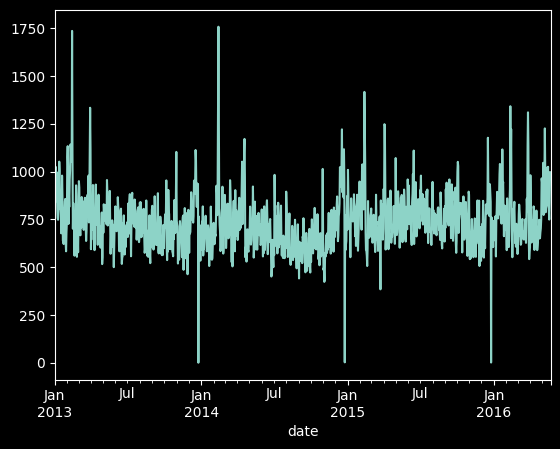

In [23]:
# Make some plots!

(
    data
    .groupby(['date', 'dept_id'])
    .sales
    .sum()
    [:, 'FOODS_1']
    .plot()
)

[Text(0.5, 1.0, 'Autocorrelation plot for aggregated month-start sales'),
 Text(0.5, 0, 'Lag (week)'),
 Text(0, 0.5, 'ACF')]

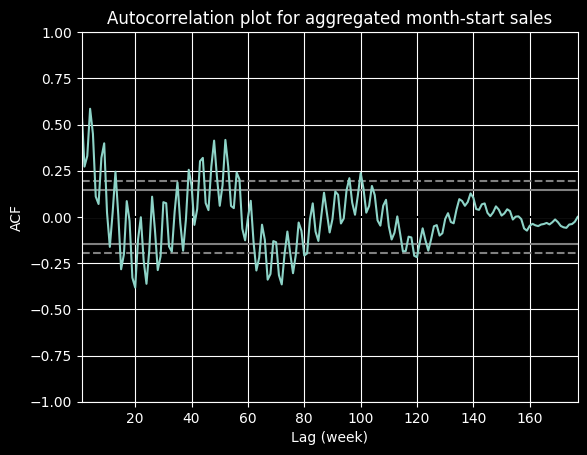

In [24]:
# ACF plots
## For aggregated weekly series - shows strong weekly correlations at lags 2, 20 and 52 weeks
(
    data
    .groupby(pd.Grouper(level='date', freq='W'))
    .sales
    .sum()
    .pipe(lambda df: pd.plotting.autocorrelation_plot(df))
    .set(title='Autocorrelation plot for aggregated month-start sales', xlabel='Lag (week)', ylabel='ACF')
)

[Text(0.5, 1.0, 'Weekly ACF Plot for FOODS_1'),
 Text(0.5, 1.0, 'Weekly ACF Plot for FOODS_2'),
 Text(0.5, 1.0, 'Weekly ACF Plot for FOODS_3'),
 Text(0.5, 1.0, 'Weekly ACF Plot for HOBBIES_1'),
 Text(0.5, 1.0, 'Weekly ACF Plot for HOBBIES_2'),
 Text(0.5, 1.0, 'Weekly ACF Plot for HOUSEHOLD_1'),
 Text(0.5, 1.0, 'Weekly ACF Plot for HOUSEHOLD_2')]

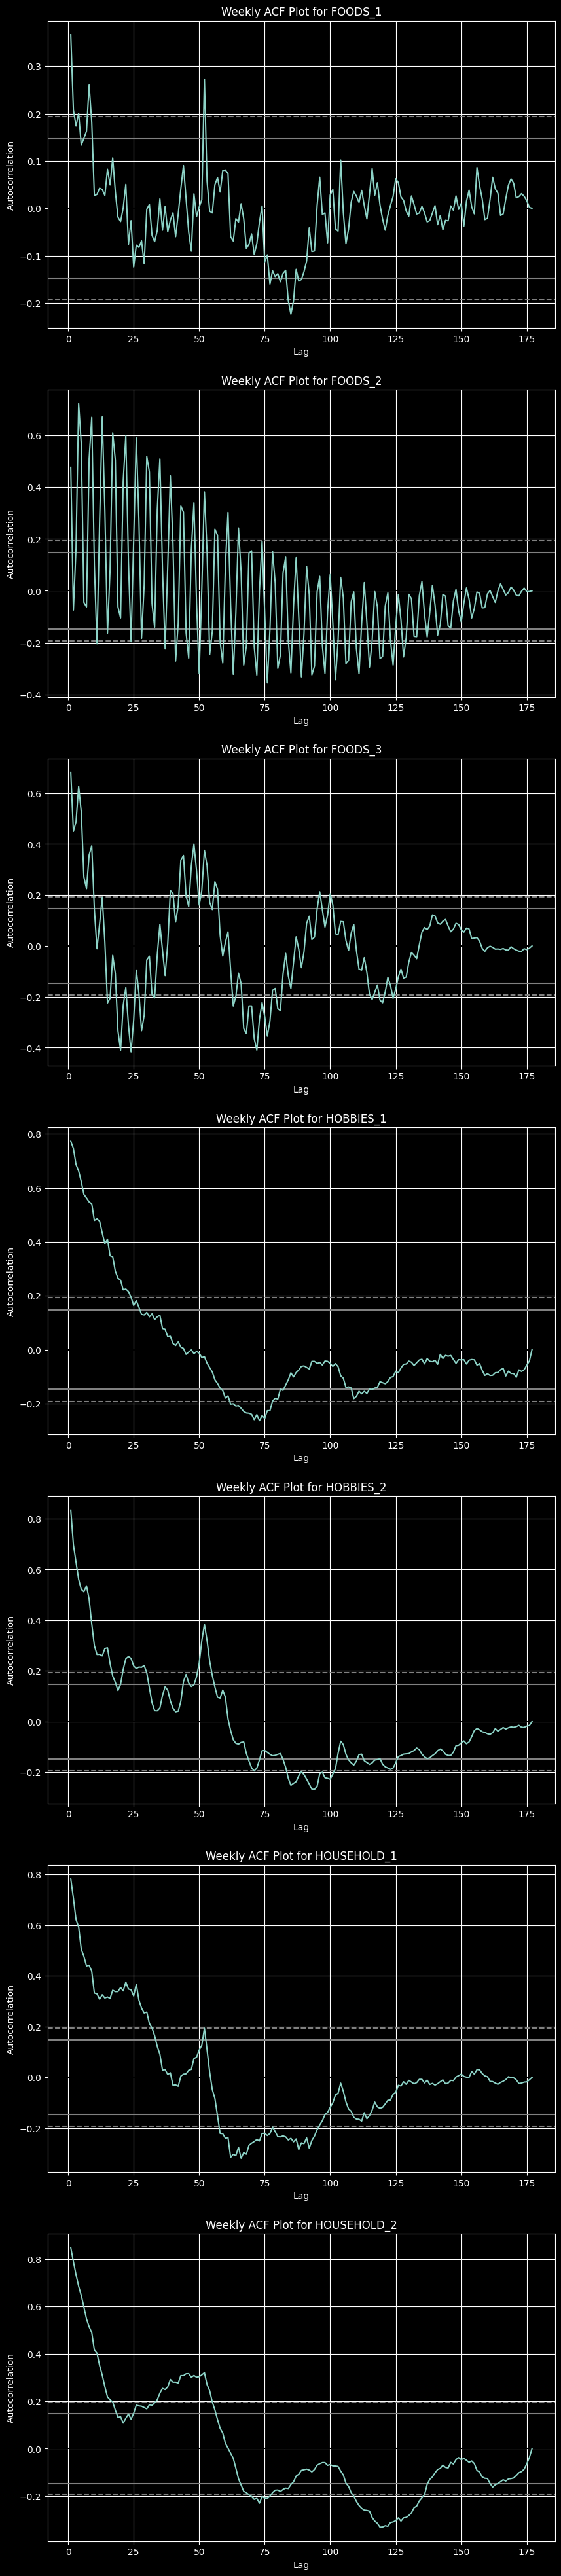

In [25]:
# ACF plots
## For multiple dept weekly series 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(len(data['dept_id'].unique()), figsize=(10, 50))

(
    data
    .groupby(['dept_id'])
    .resample(level='date', rule='W')
    .sales
    .sum()
    .unstack('dept_id')
    .pipe(lambda df: [
        pd.plotting.autocorrelation_plot(
            df[col], 
            ax = ax[i]
        )
        .set_title(f'Weekly ACF Plot for {col}') for i, col in enumerate(df.columns)])
)

[<Axes: title={'center': 'FOODS_1'}, xlabel='date'>,
 <Axes: title={'center': 'FOODS_2'}, xlabel='date'>,
 <Axes: title={'center': 'FOODS_3'}, xlabel='date'>,
 <Axes: title={'center': 'HOBBIES_1'}, xlabel='date'>,
 <Axes: title={'center': 'HOBBIES_2'}, xlabel='date'>,
 <Axes: title={'center': 'HOUSEHOLD_1'}, xlabel='date'>,
 <Axes: title={'center': 'HOUSEHOLD_2'}, xlabel='date'>]

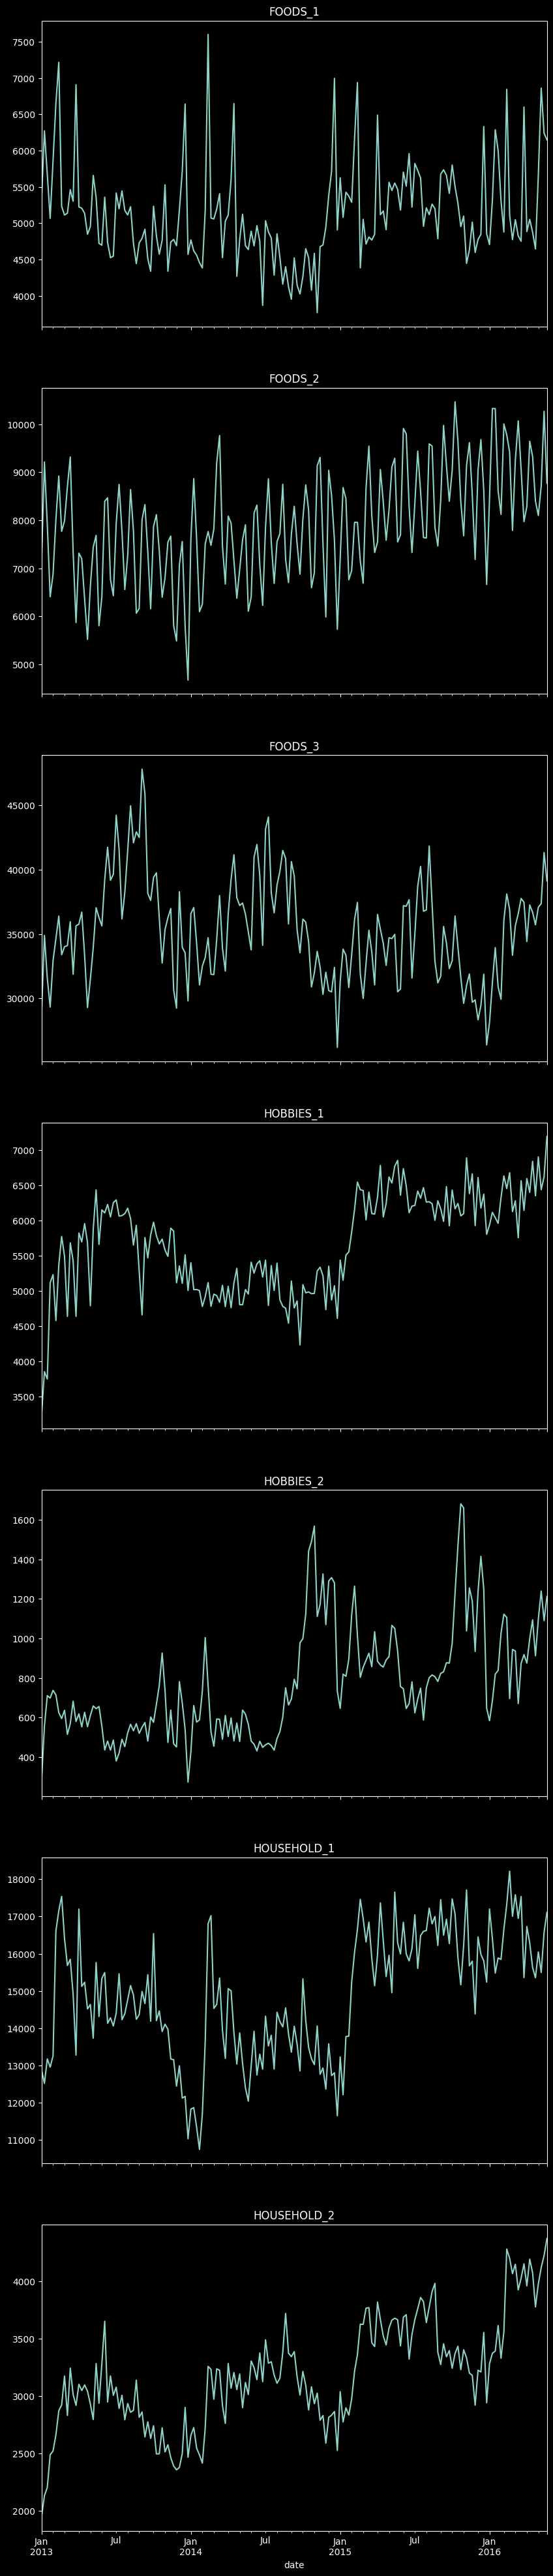

In [26]:
# Weekly plots by dept_id

fig, ax = plt.subplots(len(data['dept_id'].unique()), figsize=(10, 50))

(
    data
    .groupby(['dept_id'])
    .resample(level='date', rule='W')
    .sales
    .sum()
    .unstack('dept_id')
    .pipe(lambda df: [
        df[col].plot(ax = ax[i], title=f'{col}', sharex = True) for i, col in enumerate(df.columns)
    ])
)

[Text(0.5, 1.0, '\nFOODS_1'),
 Text(0.5, 1.0, '\nFOODS_2'),
 Text(0.5, 1.0, '\nFOODS_3'),
 Text(0.5, 1.0, '\nHOBBIES_1'),
 Text(0.5, 1.0, '\nHOBBIES_2'),
 Text(0.5, 1.0, '\nHOUSEHOLD_1'),
 Text(0.5, 1.0, '\nHOUSEHOLD_2')]

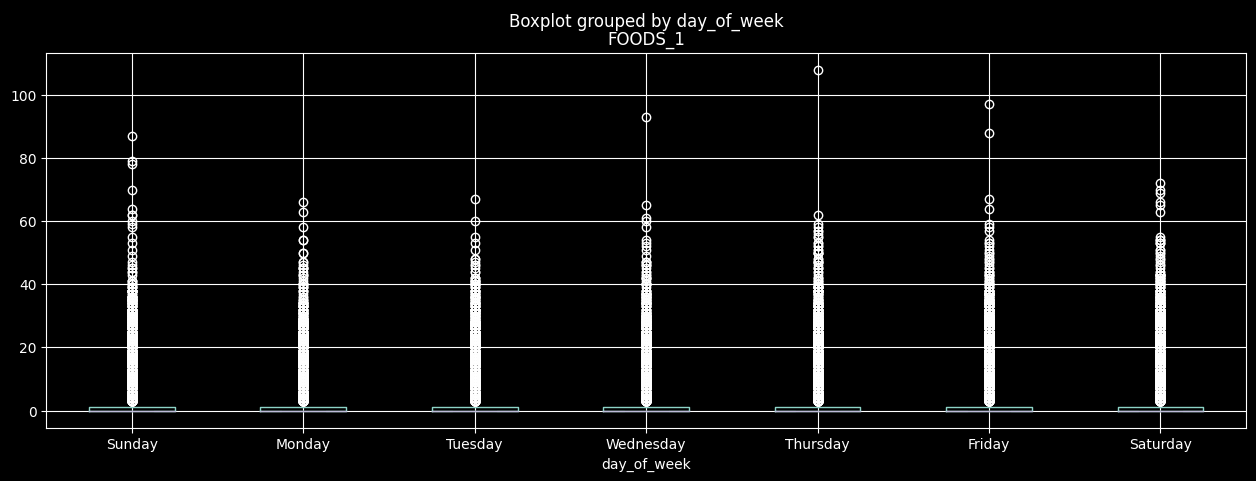

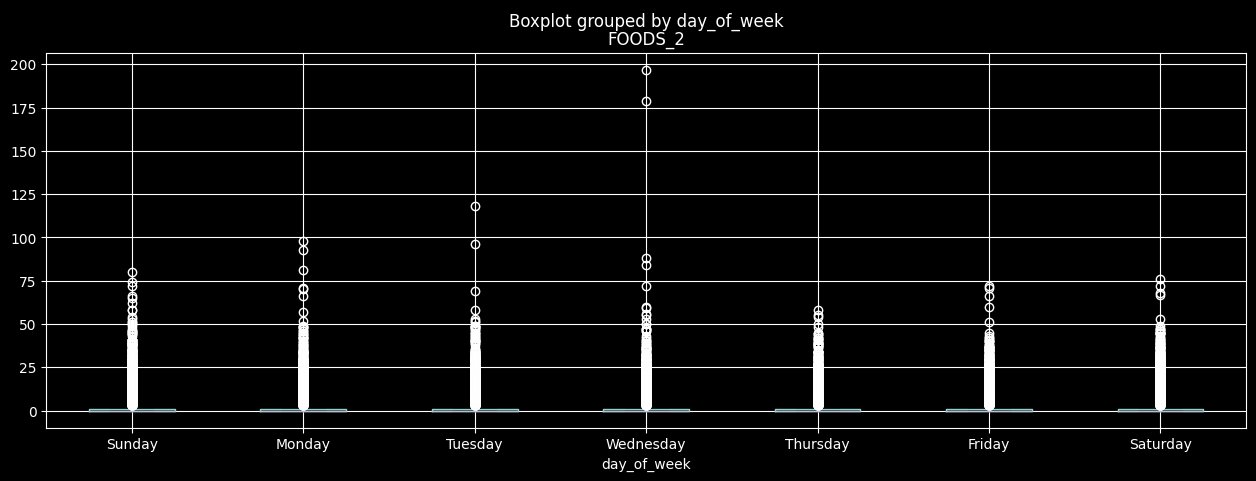

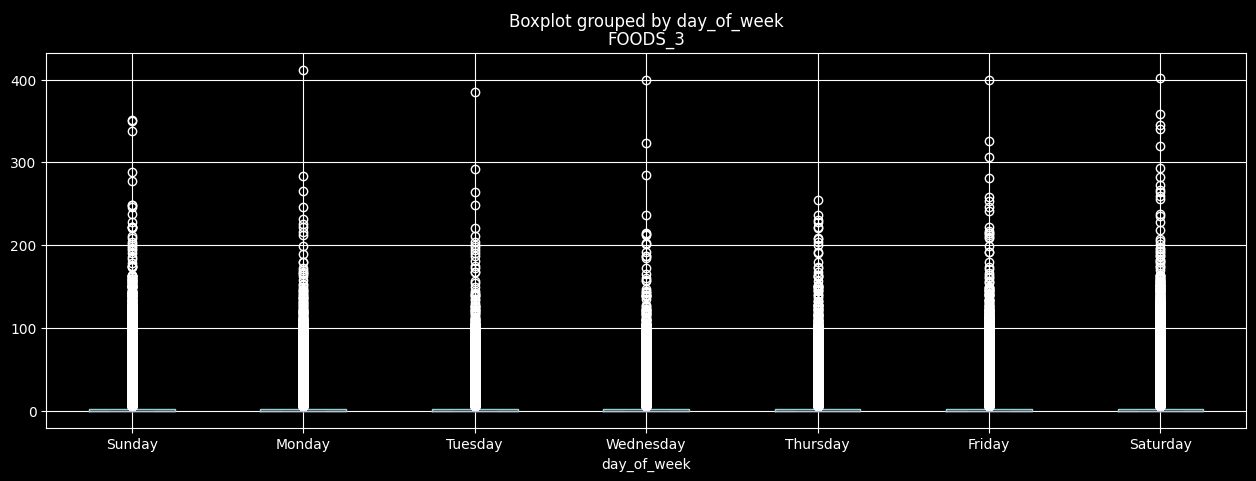

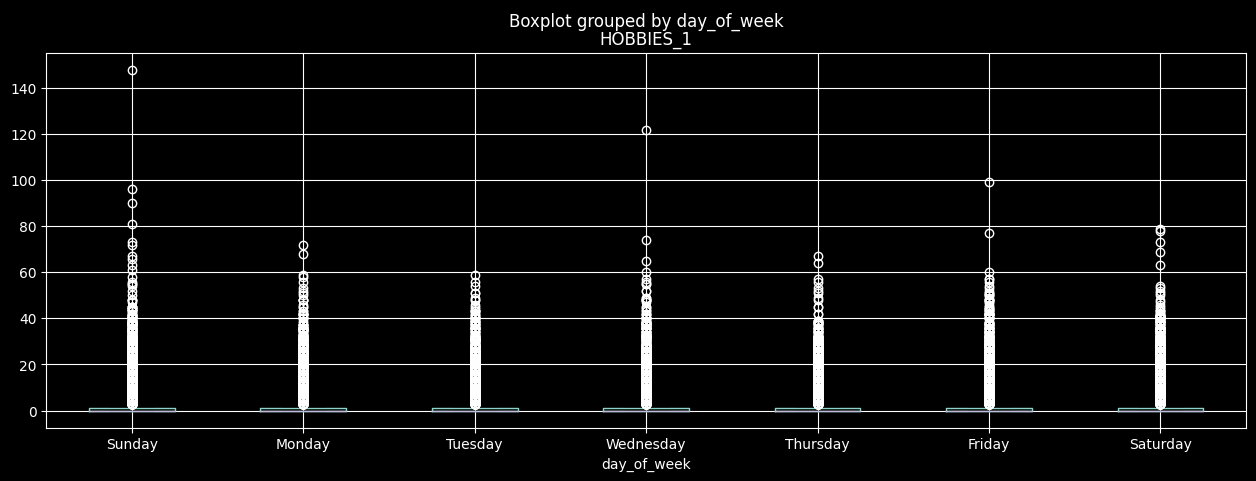

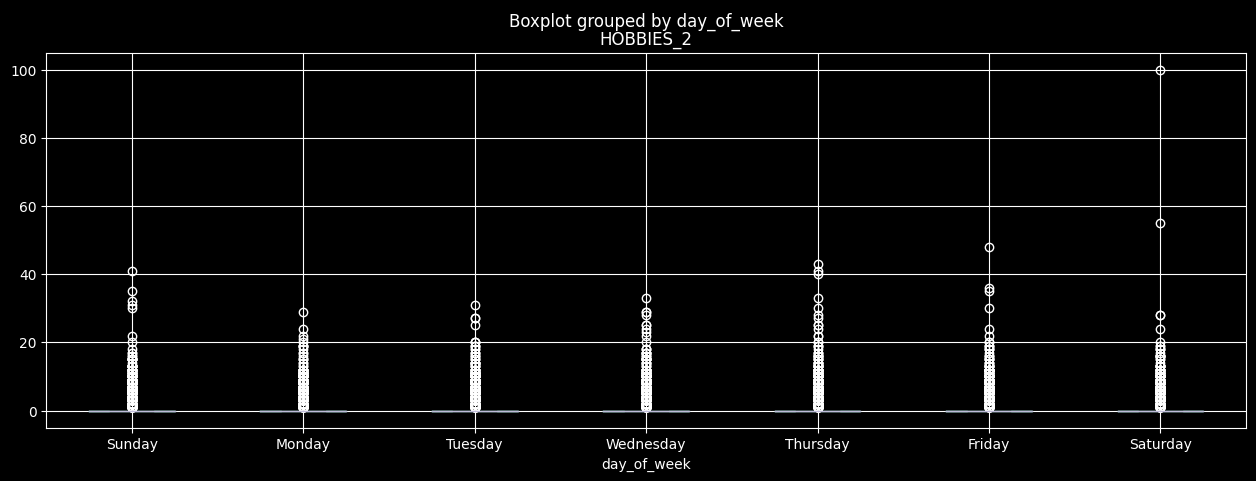

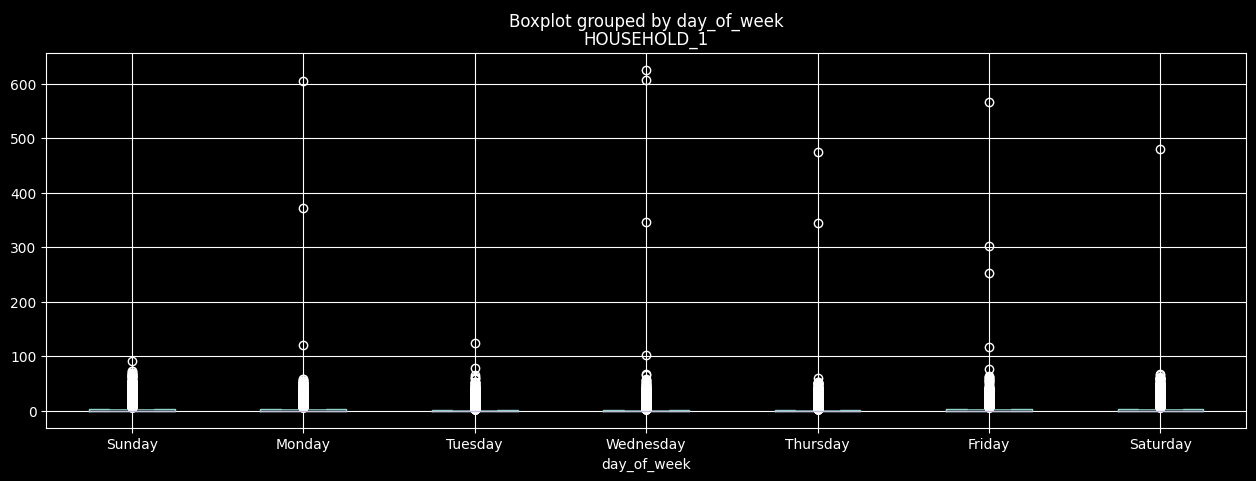

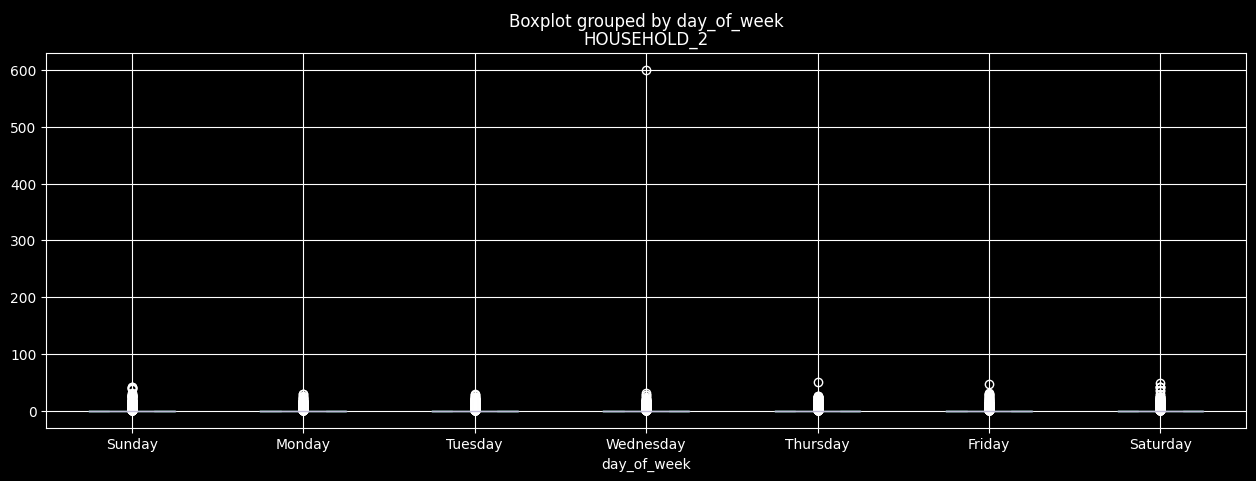

In [27]:
# Day of the week plots by dept_id

(
    data
    .assign(day_of_week=lambda df: df.index.get_level_values('date').day_name().astype('category').reorder_categories(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']))
    # .query('dept_id == "FOODS_1"')
    .pipe(lambda df: [df[df.dept_id == dept].boxplot(column='sales', by='day_of_week', figsize =(15,5)).set_title(f'\n{dept}') for dept in df.dept_id.unique()])
)


## Training some models!

Finally, we can train some models!

We're going to use the [statsforecast](https://github.com/Nixtla/statsforecast) library, since it makes training statistical time-series models really easy. There are other great libraries (like [darts](https://unit8co.github.io/darts/), which is more mature of a package) but I like `statsforecast` a bit more for these models. Eventually, we'll get to training our own models from scratch.

Here's what you need to do:

1. Aggregate sales up to the `date`/`dept_id` level so each date has 7 distinct records (one for each `dept_id`).
2. Convert your aggregated data into the [format that `statsforecast` likes](https://nixtla.github.io/statsforecast/examples/getting_started_short.html).
3. Fit and evaluate some models! This part is made straightforward by `statsforecast` so feel free to fit whatever you want, but focus on models like [this one](https://nixtla.github.io/statsforecast/models.html#arima-family) and [this one](https://nixtla.github.io/statsforecast/models.html#holt-winters-method) since we discussed them. Their documentation has a [quickstart](https://nixtla.github.io/statsforecast/examples/getting_started_short.html) to get going. I provided you with some helper code below to get started.
    - Play around with `ARIMA` and `HoltWinters` and tune them using your intution, then compare them to [`AutoARIMA`](https://nixtla.github.io/statsforecast/models.html#autoarima) and [`AutoETS`](https://nixtla.github.io/statsforecast/models.html#autoets), which do the tuning for you!
4. (If your time permits) try out other libraries! Go try to fit a [Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api) model, fit some models using `darts` and see how they compare, etc.

In [28]:
# You'll see a lot of "WARNING: Retrying" outputs if you don't have internet enabled
# This happens because you haven't verified your phone number for your Kaggle profile.
# To do that, you'll need to exit the notebook, go to your profile, go to "account", and verify your phone number.
# Other than that, don't worry about any error outputs you see from this
# ! pip install statsforecast==1.5.0

In [29]:
from statsforecast import StatsForecast
from statsforecast.models import ARIMA, HoltWinters

C:\Users\nisar\AppData\Roaming\Python\Python310\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [30]:
from tqdm.autonotebook import tqdm

In [31]:
# Aggregate data to date/dept_id level

train_data = data.groupby(['date', 'dept_id']).sales.agg('sum').reset_index()
train_data.head()

,date,dept_id,sales
0,2013-01-01,FOODS_1,727
1,2013-01-01,FOODS_2,892
2,2013-01-01,FOODS_3,4230
3,2013-01-01,HOBBIES_1,412
4,2013-01-01,HOBBIES_2,37


In [32]:
df = train_data.rename(columns={
    'dept_id': 'unique_id',
    'date': 'ds',
    'sales': 'y'
})
train_df = df[df.ds < pd.Timestamp('2016-04-24')]

sf = StatsForecast(
    models=[
        # SARIMA(1, 1, 1)(1, 1, 1),7
        ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1), season_length=7),
        # ETS model
        HoltWinters(season_length=7)
    ],
    freq='D'
)
sf.fit(train_df)

StatsForecast(models=[ARIMA,HoltWinters])

In [33]:
forecast_df = sf.predict(h=28)
forecast_df.tail()

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


,ds,ARIMA,HoltWinters
unique_id,,,
HOUSEHOLD_2,2016-05-17,503.164734,504.839935
HOUSEHOLD_2,2016-05-18,508.078491,508.097931
HOUSEHOLD_2,2016-05-19,527.373230,521.676636
HOUSEHOLD_2,2016-05-20,554.838684,564.961609
HOUSEHOLD_2,2016-05-21,680.278992,669.920959


These are `plotly` charts, which are interactive. If you're not familiar, you can:
- Click a series name in the legend (on the right) to activate/deactivate it in the plots
- Hover your mouse over the plots and click + drag to zoom in
- Double click on the plots to zoom back out

In [34]:
sf.plot(df, forecast_df)

In [36]:
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    CrostonClassic as Croston, 
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)

In [41]:
models = [
    AutoARIMA(season_length=7*2),
    HoltWinters(season_length=7*2),
    Croston(),
    SeasonalNaive(season_length=7*2),
    HistoricAverage(),
    DOT(season_length=7)
]

sf = StatsForecast(
    df=df,
    models=models, 
    freq='D'
)

forecast_df = sf.forecast(h=28, level=[90])

forecast_df.head

<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast



<bound method NDFrame.head of                     ds   AutoARIMA  AutoARIMA-lo-90  AutoARIMA-hi-90  \
unique_id                                                              
FOODS_1     2016-05-23  872.346130       674.184265      1070.507935   
FOODS_1     2016-05-24  843.712708       623.942871      1063.482544   
FOODS_1     2016-05-25  828.488953       603.596375      1053.381592   
FOODS_1     2016-05-26  830.474121       604.079956      1056.868286   
FOODS_1     2016-05-27  867.777771       640.813232      1094.742310   
...                ...         ...              ...              ...   
HOUSEHOLD_2 2016-06-15  499.469147       391.514771       607.423523   
HOUSEHOLD_2 2016-06-16  506.083160       398.128784       614.037537   
HOUSEHOLD_2 2016-06-17  562.414795       454.460419       670.369141   
HOUSEHOLD_2 2016-06-18  676.326721       568.372375       784.281128   
HOUSEHOLD_2 2016-06-19  669.467285       561.512878       777.421631   

             HoltWinters  HoltWin

In [42]:
sf.plot(df, forecast_df)